In [1]:
import h5py

In [ ]:
with h5py.File('../mvtec_dataset.h5', 'r') as f:
    def print_name(name):
        print(name, f[name].shape if hasattr(f[name], 'shape') else '')
    f.visit(print_name)

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from src.data_loader import H5Dataset, MVTecDataset
from src.main_utils import build_parser
from src.training.losses import vae_loss
from src.models.vanilla_vae import VAE
from src.evaluation.evaluate import detect_anomaly

In [3]:
def vae_loss(
    recon_x: torch.Tensor,
    x: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
    beta: float = 1.0,
    reduction: str = "mean",  # Changed to mean for consistent reduction
) -> dict:
    """
    Compute VAE loss components: reconstruction loss and KL divergence.
    """
    batch_size = x.size(0)
    
    # Reconstruction loss - use consistent reduction
    if reduction == "mean":
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        # Multiply by number of elements to get proper scaling compared to KL
        num_pixels = x.size(1) * x.size(2) * x.size(3)
        recon_loss = recon_loss * num_pixels
    else:  # sum
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Normalize by batch size for consistent scaling
    if reduction == "mean":
        kl_loss = kl_loss / batch_size
        recon_loss = recon_loss / batch_size
    
    total_loss = recon_loss + beta * kl_loss

    return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

In [3]:
# Model parameters
input_channels = 3
latent_dim = 128
hidden_layers = [64, 128, 256, 512]
num_workers = min(8, os.cpu_count()// 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [26]:
model_dir = './experiments/metal_nut/metal_nut_baseline_beta1.0_seed42/models'

model_path = os.path.join(model_dir, 'best_model.pt')
print(f'complete path including os: {model_path}')

model = VAE(input_channels=input_channels, latent_dim=latent_dim, hidden_layers=hidden_layers).to(device)
#model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.eval()
print(model)

complete path including os: ./experiments/metal_nut/metal_nut_baseline_beta1.0_seed42/models/best_model.pt
VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (fc_mu): Linear(in_features=32768, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=32768, out_features=128, bias=

In [27]:
# data loading 
dataset_name = 'mvtec_dataset.h5'

dataset = MVTecDataset(class_name='metal_nut', split='train')

dataset_size = len(dataset)

val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_subset, val_subset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

train_loader =  DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=True)


#data_loader = DataLoader(dataset, batch_size=dataset_size, shuffle=False, num_workers=num_workers, pin_memory=True)



In [28]:
print(type(next(iter(train_loader))))

<class 'torch.Tensor'>


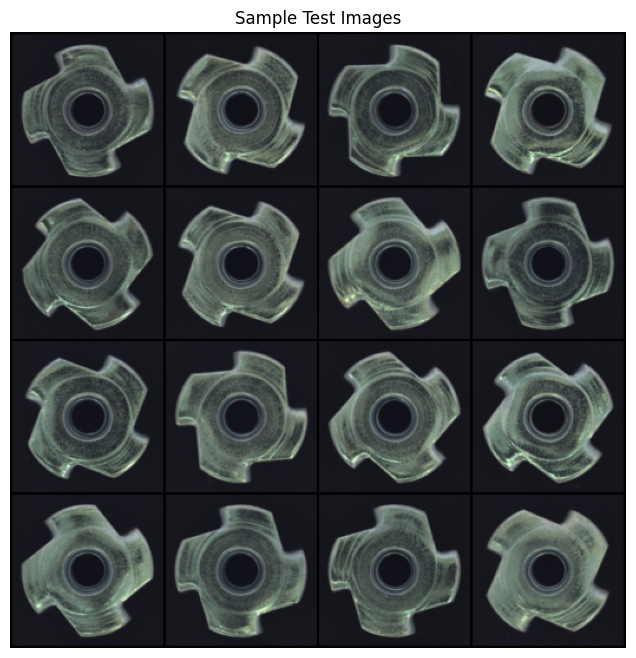

In [29]:
# visualize data 

# get some random training images
img = next(iter(train_loader))
# show images with pyplot
img_grid = torchvision.utils.make_grid(img, nrow=4)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
plt.title('Sample Test Images')
plt.axis('off')
plt.show()

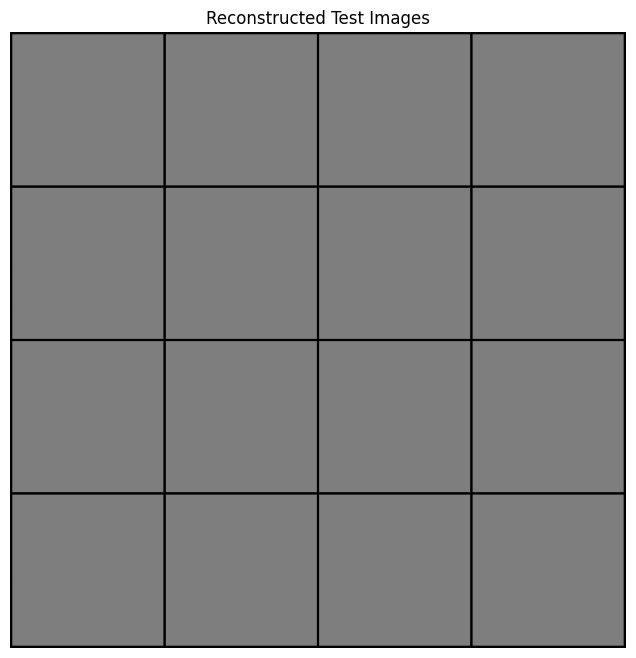

In [30]:
# reconstruct images 

with torch.no_grad():
    recon_img, mu, logvar = model(img.to(device))
    recon_img = recon_img.cpu()
    # show images with pyplot
    recon_grid = torchvision.utils.make_grid(recon_img, nrow=4)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(recon_grid.numpy(), (1, 2, 0)))
    plt.title('Reconstructed Test Images')
    plt.axis('off')
    plt.show()


In [31]:
print(recon_img.shape)
print(recon_img.min(), recon_img.max())

torch.Size([16, 3, 128, 128])
tensor(0.4940) tensor(0.5044)


In [32]:
# train model with vae loss

epochs = 50
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

model.train()

for epoch in range(epochs):
    model.train()
    
    train_loss = 0.0
    train_recon_loss = 0.0
    train_kl_loss = 0.0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        losses = vae_loss(recon, data, mu, logvar, beta=1.0)
        loss = losses['loss']
        recon_loss = losses['recon_loss']
        kl_loss = losses['kl_loss']
        
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = train_recon_loss / len(train_loader)
    avg_kl_loss = train_kl_loss / len(train_loader)

    model.eval()
    
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0

    with torch.no_grad():


        for _, data in enumerate(val_loader):
            data = data.to(device)
            recon, mu, logvar = model(data)
            losses = vae_loss(recon, data, mu, logvar, beta=1.0)
            val_loss += losses['loss'].item()
            val_recon_loss += losses['recon_loss'].item()
            val_kl_loss += losses['kl_loss'].item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_recon_loss = val_recon_loss / len(val_loader)
    avg_val_kl_loss = val_kl_loss / len(val_loader) 

    scheduler.step(avg_val_loss)



    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}')

Epoch [1/50], Loss: 812722.7387, Recon Loss: 145.0902, KL Loss: 812577.6056
Val Loss: 11486.8617, Val Recon Loss: 156.1349, Val KL Loss: 11330.7269
Epoch [2/50], Loss: 2151.2594, Recon Loss: 86.4770, KL Loss: 2064.7824
Val Loss: 30613.6725, Val Recon Loss: 194.8486, Val KL Loss: 30418.8242
Epoch [3/50], Loss: 1501.1633, Recon Loss: 67.4343, KL Loss: 1433.7289
Val Loss: 23896.8522, Val Recon Loss: 181.7774, Val KL Loss: 23715.0749
Epoch [4/50], Loss: 1196.7497, Recon Loss: 56.7290, KL Loss: 1140.0207
Val Loss: 21281.7542, Val Recon Loss: 227.6889, Val KL Loss: 21054.0658
Epoch [5/50], Loss: 978.7694, Recon Loss: 50.8718, KL Loss: 927.8976
Val Loss: 2338.2745, Val Recon Loss: 96.9118, Val KL Loss: 2241.3626
Epoch [6/50], Loss: 744.6651, Recon Loss: 45.3341, KL Loss: 699.3310
Val Loss: 820.1482, Val Recon Loss: 50.7238, Val KL Loss: 769.4245
Epoch [7/50], Loss: 523.2061, Recon Loss: 38.8804, KL Loss: 484.3257
Val Loss: 685.6242, Val Recon Loss: 41.5399, Val KL Loss: 644.0843
Epoch [8/50],

In [33]:
print(recon_img.shape)
print(recon_img.min(), recon_img.max())

torch.Size([16, 3, 128, 128])
tensor(0.4940) tensor(0.5044)


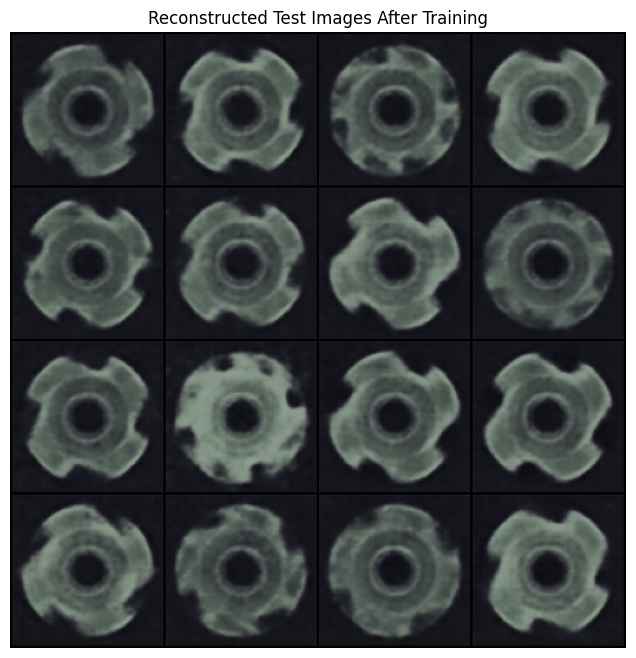

In [34]:
# reconstruct images after training
with torch.no_grad():
    recon_img, mu, logvar = model(img.to(device))
    recon_img = recon_img.cpu()
    # show images with pyplot
    recon_grid = torchvision.utils.make_grid(recon_img, nrow=4)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(recon_grid.numpy(), (1, 2, 0)))
    plt.title('Reconstructed Test Images After Training')
    plt.axis('off')
    plt.show()

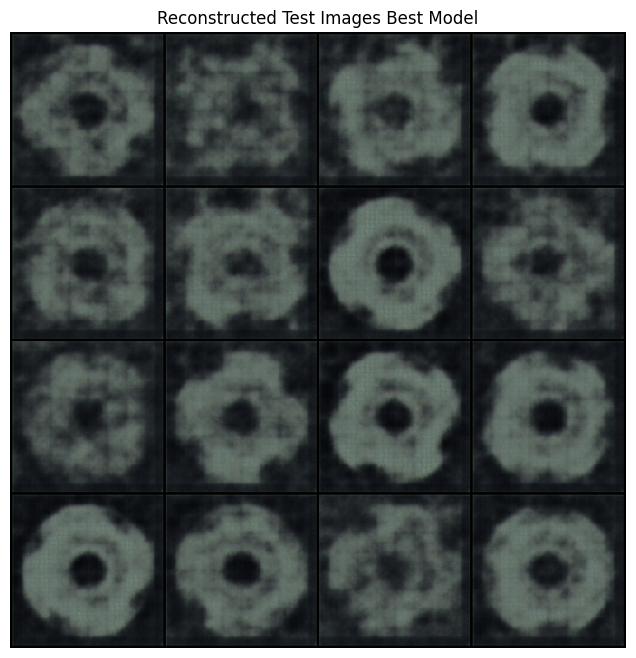

In [35]:
# load best model and show reconstructions
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.eval()

with torch.no_grad():
    recon_img, mu, logvar = model(img.to(device))
    recon_img = recon_img.cpu()
    # show images with pyplot
    recon_grid = torchvision.utils.make_grid(recon_img, nrow=4)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(recon_grid.numpy(), (1, 2, 0)))
    plt.title('Reconstructed Test Images Best Model')
    plt.axis('off')
    plt.show()